# Chapter 6

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# check if the libraries we need are installed

try:
    import pint
except ImportError:
    !pip install pint
    import pint
    
try:
    import modsim
except ImportError:
    !pip install modsimpy
    from modsim import *

In the previous chapter we simulated a model of world population with
constant growth. In this chapter we see if we can make a better model
with growth proportional to the population.

But first, we'll improve the code from the previous chapter by
encapsulating it in a function and using `System` objects.

Here's the code that reads the data.

In [2]:
import os

filename = 'World_population_estimates.html'

if not os.path.exists(filename):
    !wget https://raw.githubusercontent.com/AllenDowney/ModSimPy/master/data/World_population_estimates.html

In [3]:
from pandas import read_html

tables = read_html(filename, header=0, index_col=0, decimal='M')
table2 = tables[2]
table2.columns = ['census', 'prb', 'un', 'maddison', 
                  'hyde', 'tanton', 'biraben', 'mj', 
                  'thomlinson', 'durand', 'clark']

## System objects

Like a `State` object, a `System` object contains variables and their
values. The difference is:

-   `State` objects contain state variables that get updated in the course of a simulation.

-   `System` objects contain **system parameters**, which usually don't get updated over the course of a simulation.

For example, in the bike share model, state variables include the number of bikes at each location, which get updated whenever a customer moves a bike. System parameters include the number of locations, total number of bikes, and arrival rates at each location.

In the population model, the only state variable is the population.
System parameters include the annual growth rate, the initial time and
population, and the end time.

Suppose we have the following variables, as computed in the previous
chapter (assuming `table2` is the `DataFrame` we read from the file):

In [4]:
un = table2.un / 1e9
census = table2.census / 1e9

t_0 = census.index[0]
t_end = census.index[-1]
elapsed_time = t_end - t_0

p_0 = census[t_0]
p_end = census[t_end]

total_growth = p_end - p_0
annual_growth = total_growth / elapsed_time

Some of these are parameters we need to simulate the system; others are temporary values we can discard. 
To distinguish between them, we'll put the parameters we need into a `System` object like this:

In [5]:
from modsim import System

system = System(t_0=t_0, 
                t_end=t_end,
                p_0=p_0,
                annual_growth=annual_growth)

`t0` and `t_end` are the first and last years; `p_0` is the initial
population, and `annual_growth` is the estimated annual growth.

Here's what `system` looks like.

In [6]:
system

,System
t_0,1950.0
t_end,2016.0
p_0,2.557629
annual_growth,0.072248


Next we'll wrap the code from the previous chapter in a function:

In [7]:
from modsim import TimeSeries

def run_simulation1(system):
    results = TimeSeries()
    results[system.t_0] = system.p_0
    
    for t in range(system.t_0, system.t_end):
        results[t+1] = results[t] + system.annual_growth
    
    return results

`run_simulation1` takes a `System` object and uses the parameters in it to determine `t_0`, `t_end`, and `annual_growth`.

Inside the loop, it stores the results in a `TimeSeries` which it returns at the end.

The following function plots the results along with the estimates
`census` and `un`:



Here's how we call it.

In [8]:
results1 = run_simulation1(system)

Here's the function we used in the previous chapter to plot the estimates.

In [9]:
from modsim import decorate

def plot_estimates():
    census.plot(style=':', label='US Census')
    un.plot(style='--', label='UN DESA')
    decorate(xlabel='Year', 
             ylabel='World population (billion)') 

And here are the results.

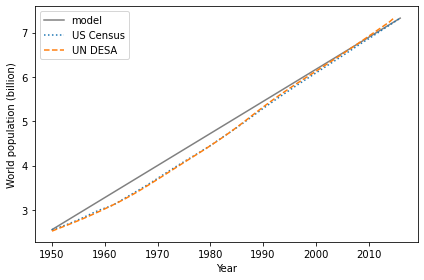

In [10]:
results1.plot(label='model', color='gray')
plot_estimates()
decorate(title='Constant Growth Model')

It might not be obvious that using functions and `System` objects is a
big improvement, and for a simple model that we run only once, maybe
it's not. But as we work with more complex models, and when we run many simulations with different parameters, we'll see that the organization of the code makes a big difference.

Now let's see if we can improve the model.

## Proportional growth model

The biggest problem with the constant growth model is that it doesn't
make any sense. It is hard to imagine how people all over the world
could conspire to keep population growth constant from year to year.

On the other hand, if some fraction of the population dies each year,
and some fraction gives birth, we can compute the net change in the
population like this:

In [11]:
def run_simulation2(system):
    results = TimeSeries()
    results[system.t_0] = system.p_0
    
    for t in range(system.t_0, system.t_end):
        births = system.birth_rate * results[t]
        deaths = system.death_rate * results[t]
        results[t+1] = results[t] + births - deaths
        
    return results

Now we can choose the values of `birth_rate` and `death_rate` that best fit the data. 

For the death rate, I'll use 7.7 deaths per 1000 people, which was roughly the global death rate in 2020 (see <https://www.indexmundi.com/world/death_rate.html>).
I chose the birth rate by hand to fit the data.

In [12]:
system.death_rate = 7.7 / 1000
system.birth_rate = 25 / 1000

Then I ran the simulation and plotted the results:

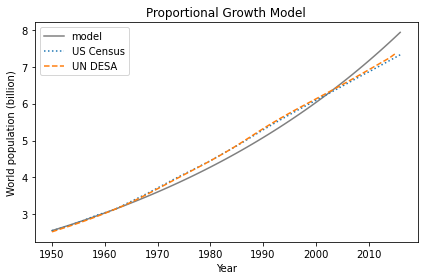

In [13]:
results2 = run_simulation2(system)
results2.plot(label='model', color='gray')
plot_estimates()
decorate(title='Proportional Growth Model')

The proportional model fits
the data well from 1950 to 1965, but not so well after that. Overall,
the **quality of fit** is not as good as the constant growth model,
which is surprising, because it seems like the proportional model is
more realistic.

In the next chapter we'll try one more time to find a model that makes
sense and fits the data. But first, I want to make a few more
improvements to the code.

## Factoring out the update function

`run_simulation1` and `run_simulation2` are nearly identical except for the body of the `for` loop, where we compute the population for the next year.

Rather than repeat identical code, we can separate the things that
change from the things that don't. First, I'll pull out the update code from `run_simulation2` and make it a function:

In [14]:
def growth_func1(pop, t, system):
    births = system.birth_rate * pop
    deaths = system.death_rate * pop
    return births - deaths

This function takes as arguments the current population, current year,
and a `System` object; it returns the net population growth during the current year.

This update function does not use `t`, so we could leave it out. But we will see other functions that need it, and it is convenient if they all take the same parameters, used or not.

Now we can write a function that runs any model:

In [15]:
def run_simulation(system, growth_func):
    results = TimeSeries()
    results[system.t_0] = system.p_0
    
    for t in range(system.t_0, system.t_end):
        growth = growth_func(results[t], t, system)
        results[t+1] = results[t] + growth
        
    return results

This function demonstrates a feature we have not seen before: it takes a
function as a parameter! When we call `run_simulation`, the second
parameter is a function, like `growth_func1`, that computes the
population for the next year.

Here's how we call it:

In [16]:
results = run_simulation(system, growth_func1)

Passing a function as an argument is the same as passing any other
value. The argument, which is `growth_func1` in this example, gets
assigned to the parameter, which is called `growth_func`. Inside
`run_simulation`, we can run `growth_func` just like any other function.

Each time through the loop, `run_simulation` calls `growth_func1` to compute net growth, and uses it to compute the population during the next year.

## Combining birth and death

We can simplify the code slightly by combining births and deaths to compute the net growth rate. 
Instead of two parameters, `birth_rate` and `death_rate`, we can write the update function in terms of a single parameter that represents the difference:

In [17]:
system.alpha = system.birth_rate - system.death_rate

The name of this parameter, `alpha`, is the conventional name for a
proportional growth rate.

Here's the modified version of `growth_func1`:

In [18]:
def growth_func2(pop, t, system):
    return system.alpha * pop

And here's how we run it:

In [19]:
results = run_simulation(system, growth_func2)

The results are the same as the previous versions, but now the code is organized in a way that makes it easy to explore other models.

## Summary

In this chapter, we wrapped the code from the previous chapter in functions and used a `System` object to store the parameters of the system.

We explored a new model of population growth, where the number of births and deaths is proportional to the current population.  This model seems more realistic, but it turns out not to fit the data particularly well.

In the next chapter, we'll try one more model, which is based on the assumption that the population can't keep growing forever.
But first, you might want to work on some exercises.

## Exercises

**Exercise:** Maybe the reason the proportional model doesn't work very well is that the growth rate, `alpha`, is changing over time.  So let's try a model with different growth rates before and after 1980 (as an arbitrary choice).

Write an update function that takes `pop`, `t`, and `system` as parameters.  The system object, `system`, should contain two parameters: the growth rate before 1980, `alpha1`, and the growth rate after 1980, `alpha2`.  It should use `t` to determine which growth rate to use.

Test your function by calling it directly, then pass it to `run_simulation`.  Plot the results.  Adjust the parameters `alpha1` and `alpha2` to fit the data as well as you can.

In [20]:
# Solution

def growth_func3(pop, t, system):
    """Compute the population next year.
    
    pop: current population
    t: current year
    system: system object containing parameters of the model
    
    returns: population next year
    """
    if t < 1980:
        return system.alpha1 * pop
    else:
        return system.alpha2 * pop

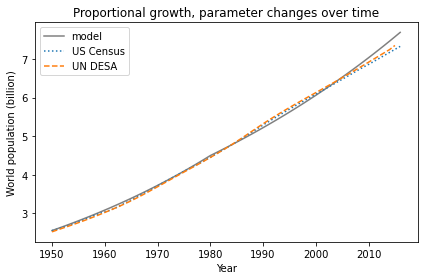

In [21]:
# Solution

system.alpha1 = 19 / 1000
system.alpha2 = 15 / 1000

results3 = run_simulation(system, growth_func3)
results3.plot(label='model', color='gray')
plot_estimates()
decorate(title='Proportional growth, parameter changes over time')

In [22]:
# Solution

# Using two parameters, we can make the model fit the data better.
# But it still seems like the shape of the function is not right.